## Import libraries and set up functions
Starting directory is this "..\\asset" from this notebook code

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
import cv2
import matplotlib.pyplot as plt
import random
#from keras.backend import clear_session
#from keras.backend import get_session
import time
import math
from datetime import timedelta
# import mediapipe as mp
import csv
import pandas as pd
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
# for naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix 
import seaborn as sns 

os.chdir("..\\asset") # change working directory

In [3]:
emotionList = ('Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt')
TRAINANNOTATIONPATH = "train_set\\annotations\\"
TRAINIMAGEPATH = "train_set\\images\\"
TRAINLANDMARKPATH = "train_set\\landmarks\\"
TESTANNOTATIONPATH = "val_set\\annotations\\"
TESTIMAGEPATH = "val_set\\images\\"
TESTLANDMARKPATH = "val_set\\landmarks\\"

def LoadAllImageNames(filePath, limit = 0, catLimit = []):
  """Load the images names and label in tuple format (label, image name)

  Args:
      filePath (str): directory of image folder
      limit (int, optional): max number of image to load. Defaults to 0.
      catLimit (list<int>, optional): array of image count limit for each class. Defaults to []*8.

  Returns:
      list<str>: shuffled list of image names
  """
  limitCounter = [0,0,0,0,0,0,0,0]
  dataSet = []
  loadCounter = 0

  annotationPath = TRAINANNOTATIONPATH if ("train" in filePath) else TESTANNOTATIONPATH
  for file in os.scandir(filePath):
    if (limit > 0 and loadCounter > limit):
      break
  
    name = file.name[:-4] # file name w/o file extension
    if "_landmark" in name:
      name = name[:-9]
    data = np.load("{}{}_exp.npy".format(annotationPath, name)) # 
    label = int(data.item(0))

    if len(catLimit) > 0 and limitCounter[label] >= catLimit[label]:
        continue
    limitCounter[label] += 1
    loadCounter += 1

    dataSet.append((label, file.name))
    if (loadCounter%10000==0):
      print("Files loaded:{}".format(loadCounter))
  
  print("Total images loaded: ", loadCounter)
  print("Images Loaded: ", limitCounter)
  random.shuffle(dataSet)
  return dataSet

# Load the pixels of a picture to numpy.ndarray format. false for test set, true for training set
# Return image in RGB format
def LoadImage(imagePath, imageName, normalize = True):
  """Load image using numpy

  Args:
      imagePath (str): image path 
      imageName (str): image name
      normalize (bool, optional): To normalize image or not. Defaults to True.

  Returns:
      numpy array: x,y,3 array
  """
  # print("{}{}{}".format(os.getcwd(), "\\"+imagePath, imageName))
  image_array = cv2.imread("{}{}{}".format(os.getcwd(), "\\"+imagePath, imageName))
  image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
  if normalize:
    image_array = image_array/255
    
  return image_array

# Extract the daata from 0 to amount from list and return it
def CropData(list, amount):
  if (len(list) < amount):
    amount = len(list)
  croppedList = list[:amount]
  del list[:amount]
  return croppedList

def LoadImages(imagePath, list):
  label = []
  data = []
  for entries in list:
    try:
      image = LoadImage(imagePath, entries[1])
      data.append(image) 
      label.append(entries[0]) 
    except: 
      print("Failed to load training image: ", entries[1])
  npLabel = np.array(label) 
  npData = np.array(data) 
  return npLabel, npData 

# Load a list of face mesh in landmark_pb2.NormalizedLandmarkList format
def LoadFaceMeshes(faceMesh, path, list, withFace = False):
  face = []
  label = []
  data = []
  for entry in list:
    # try:
    if withFace:
      face.append(LoadImage(path, entry[1], normalize = False)) # Load image
      data.append(faceMesh.process(face[-1])) # process it into face mesh and append into data
    else:
      data.append(faceMesh.process(LoadImage(path, entry[1], normalize = False))) # Load image, process it into face mesh, and append into data
    label.append(entry[0])
    # except:
      # print("Failed to load training image: ", entry[1])

  if withFace:
    return np.array(label), np.array(data), np.array(face)
  else:
    return np.array(label), np.array(data)

# Load face mesh data in numpy array of 
def LoadFaceMeshVertices(faceMesh, path, list):
  label = []
  data = []
  for entry in list:
    # load image, process it into normalizedlandmarklist format, obtain face data from the list, convert it into vertices
    image = LoadImage(path, entry[1], normalize = False)
    multiFaceLandmarks = faceMesh.process(image).multi_face_landmarks
    if (multiFaceLandmarks == None):
      print("{} multi-face landmarks is none".format(entry[1]))
      continue
    vertices = MultiLandmarkToVertices(multiFaceLandmarks[0])
    data.append(vertices)
    label.append(entry[0])
    # except:
      # print("Failed to load training image: ", entry[1])

def LoadVertices(path, list):
  label = []
  data = []
  for entry in list:
    vertices = np.load("{}{}{}.npy".format(os.getcwd(), "\\"+path, entry[1][:-4]))
    data.append(vertices)
    label.append(entry[0])
  
  return np.array(label), np.array(data)
  
def MultiLandmarkToVertices(multiLandmark):
  verticesList = []
  for idx, landmark in enumerate(multiLandmark.landmark):
    verticesList.append([landmark.x, landmark.y, landmark.z])

  return verticesList


def InitializeModel():
  pretrained_model = tf.keras.applications.MobileNetV3Large(input_shape=(224,224,3)) # Initializing model with mobile net V3 pretrained model

  # Initializing the input and output from the model, removing last layer
  base_input = pretrained_model.layers[0].input
  base_output = pretrained_model.layers[-2].output

  # Adding 3 more layers to output side
  final_output = layers.Dense(128)(base_output) # Adding new layers, to the output side
  final_output = layers.Activation('relu')(final_output) # activating layer
  final_output = layers.Dense(64)(final_output)
  final_output = layers.Activation('relu')(final_output) # activating layer
  final_output = layers.Dense(8, activation = 'softmax')(final_output) # 8 cuz there are 8 image classifications

  new_model = keras.Model(inputs = base_input, outputs = final_output)
  # new_model.summary()
  return new_model

def ConvertToGray(image):
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  return image

def ScaleImage(image, width):
  ratio = image.shape[1]/width
  image = cv2.resize(image, (width, int(image.shape[0]/ratio)))
  return image

def DetectFace(image):
  face_roi = np.ndarray(1)
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  grayImage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  faces = faceCascade.detectMultiScale(grayImage, 1.3, 5)
  for x,y,w,h in faces:
    roi_gray = grayImage[y:y+h, x:x+w]
    roi_color = image[y:y+h, x:x+w]
    cv2.rectangle(image, (x,y), (x+w, y+h), (255,0,0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if (len(facess) == 0):
      print("Face not detected")
    else:
      for (ex,ey,ew,eh) in facess:
        face_roi = roi_color[ey:ey+eh, ex:ex+ew]
  return face_roi

def ConvertToInput(image):
  input = ScaleImage(image, 224)
  input = np.expand_dims(input, axis = 0) ## to add fourth dimension to fit model input
  input = input/255
  return input

def GetResult(model, input):
  Predictions = model.predict(input)
  print(Predictions)
  result = np.argmax(Predictions)
  return emotionList[result]

def printDataSetLabels(dataSet):
    counterList = list(range(8))
    for label, name in dataSet:
        counterList[label] += 1
    print(counterList)
    
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    # try:
    #     del classifier # this is from global space - change this as you need
    # except:
    #     pass

    # use the same config as you used to create the session
    tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9, visible_device_list="0")

class TimeHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.times = []

  def on_epoch_begin(self, batch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, batch, logs={}):
    self.times.append(time.time() - self.epoch_time_start)

  def AverageTime(self):
    sum = 0
    for time in self.times:
      sum += time
    return sum/len(self.times)

def TestModel(model, testSetData):
  # test model
  lostSum = 0
  accuracySum = 0
  count = 0
  while(len(testSetData) != 0):
    # training data
    try:
      croppedList = CropData(testSetData, 100)
      label, data = LoadImages(TESTIMAGEPATH, croppedList)
      result = model.evaluate(data, label, batch_size = 1)
      lostSum += result[0]
      accuracySum += result[1]
    except:
      print("Failed to train data")

    count += 1
    reset_keras()
  
  return lostSum/count, accuracySum/count

def TestModelWithVertices(model, dataSet):
  # test model
  lostSum = 0
  accuracySum = 0
  count = 0
  while(len(dataSet) != 0):
    # training data
    try:
      croppedList = CropData(dataSet, 100)
      label, data = LoadVertices(TESTLANDMARKPATH, croppedList)
      result = model.evaluate(data, label, batch_size = 1)
      lostSum += result[0]
      accuracySum += result[1]
    except:
      print("Failed to train data")

    count += 1
    reset_keras()
  
  return lostSum/count, accuracySum/count

def DrawFaceLandmark(label, image, landmarks):
  mp_drawing = mp.solutions.drawing_utils
  mp_drawing_styles = mp.solutions.drawing_styles
  mp_face_mesh = mp.solutions.face_mesh
  print(f'Face landmarks of {label}:')
  if not landmarks.multi_face_landmarks:
    print("unagle to locate face landmark for {}".format(label))
  annotated_image = image.copy()
  for face_landmarks in landmarks.multi_face_landmarks:
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_tesselation_style())
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_IRISES,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_iris_connections_style())
  plt.imshow(annotated_image)

## Setup directory and import image file names

In [4]:
# Get currect directory (os.getcwd() -> C:\Users\jazzt\src)

#-----------------------Start of code---------------------------
# initialise image names and label
mainTrainSet = LoadAllImageNames(TRAINLANDMARKPATH, catLimit=[5500]*8)
mainTestSet = LoadAllImageNames(TESTLANDMARKPATH, catLimit=[800]*8)

Files loaded:10000
Files loaded:20000
Files loaded:30000
Files loaded:40000
Total images loaded:  40553
Images Loaded:  [5500, 5500, 5500, 5500, 5500, 3803, 5500, 3750]
Total images loaded:  3987
Images Loaded:  [499, 500, 498, 498, 498, 500, 499, 495]


Naive Bayes accuracy: 0.3115124153498871


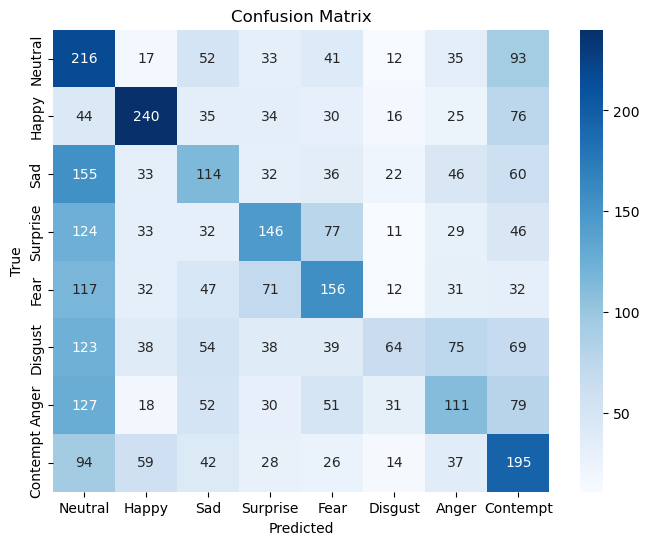

In [5]:
# Dimensionality Reduction: Since dimensionality of our feature space is high, PCA will be used to reduce the dimensionality while
# preserving most of the information.

# Make copy of data (so original data will not be modified)
train_set = mainTrainSet.copy()
test_set = mainTestSet.copy()

# Extract label and data
train_label, train_data = LoadVertices(TRAINLANDMARKPATH, train_set)
test_label, test_data = LoadVertices(TESTLANDMARKPATH, test_set)

# Flatten data for Naive Bayes
# Concatenate all arrays in 'trainData' and 'testData' along first axis and reshaping them to have a single feature dimension (two-dimensional array)
trainData = np.concatenate(train_data).reshape(len(train_data), -1)
testData = np.concatenate(test_data).reshape(len(test_data), -1)

# Normalize data (Ensures that each feature has a mean of 0 and a standard deviation of 1, which can improve performance of PCA)
scaler = StandardScaler()
train_data_normalized = scaler.fit_transform(trainData)
test_data_normalized = scaler.transform(testData)

# Apply PCA (PCA is applied to both training and test data using PCA object. n_components=0.95 ensures that
# principal components that explain at least 95% of the variance in data are retained. This reduces dimensionality of data while
# preserving most of its information.)
pca = PCA(n_components=0.999) # Keeps 95% of the variance
train_data_pca = pca.fit_transform(train_data_normalized)
test_data_pca = pca.transform(test_data_normalized)

# # Train Naive Bayes classifier
# nb_classifier = GaussianNB()
# nb_classifier.fit(train_data_pca, train_label)

# # Predict on test data
# predictions = nb_classifier.predict(test_data_pca)

# # Calc accuracy
# accuracy = accuracy_score(test_label, predictions)
# print("Naive Bayes accuracy: ", accuracy)

# Train Naive Bayes classifier 
nb_classifier = GaussianNB() 
nb_classifier.fit(train_data_pca, train_label) 
 
# Predict on test data 
predictions = nb_classifier.predict(test_data_pca) 
 
# Calculate accuracy 
accuracy = accuracy_score(test_label, predictions) 
print("Naive Bayes accuracy:", accuracy) 
 
# Generate confusion matrix 
cm = confusion_matrix(test_label, predictions) 
 
# Plot confusion matrix 
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=emotionList, yticklabels=emotionList) 
plt.xlabel('Predicted') 
plt.ylabel('True') 
plt.title('Confusion Matrix') 
plt.show()